# Convolutional Neural Networks

## Practical 2

_**Building an Image Classifier using a Pretrained Xception Model on TensorFlow Flower Dataset.**_

NOTE: This notebook is recommended to run on GPU to save time during model training.

In [1]:
# Imports required packages

import numpy as np
#import pandas as pd
import tensorflow as tf
import tensorflow_datasets as tfds    # THIS MIGHT NEED TO BE INSTALLED SEPERATELY
#from tensorflow.keras.datasets import mnist
#from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
# THE FOLLOWING OPERATION MAY TAKE SEVERAL MINUTES TO COMPLETE

tf_flowers, info = tfds.load("tf_flowers", as_supervised=True, with_info=True)

Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]

Dataset tf_flowers downloaded and prepared to /root/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.


In [3]:
dataset_size = info.splits["train"].num_examples
class_names = info.features["label"].names
n_classes = info.features["label"].num_classes

In [4]:
dataset_size

3670

In [5]:
class_names

['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses']

In [6]:
n_classes

5

In [7]:
test_set_raw, val_set_raw, train_set_raw = tfds.load(
    "tf_flowers",
    split=["train[:10%]", "train[10%:25%]", "train[25%:]"],
    as_supervised=True)

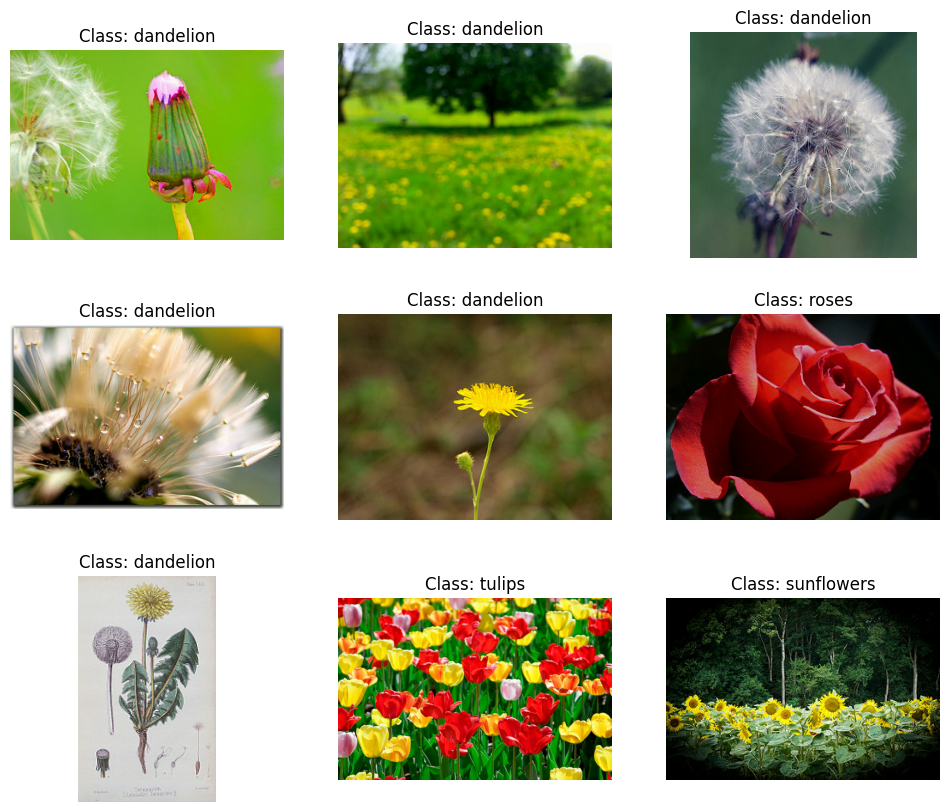

In [8]:
plt.figure(figsize=(12, 10))
index = 0
for image, label in val_set_raw.take(9):
    index += 1
    plt.subplot(3, 3, index)
    plt.imshow(image)
    plt.title(f"Class: {class_names[label]}")
    plt.axis("off")

plt.show()

As batching training instances requires instances having same size, the same is done over a Resizing layer. Function tf.keras.applications.xception.preprocess_input() also needs to be called to preprocess the images appropriately for the Xception model. Shuffling and prefetching are also added to the training dataset.

In [9]:
tf.random.set_seed(42)

batch_size = 32

preprocess = tf.keras.Sequential([
    tf.keras.layers.Resizing(height=224, width=224, crop_to_aspect_ratio=True),
    tf.keras.layers.Lambda(tf.keras.applications.xception.preprocess_input)
])

train_set = train_set_raw.map(lambda X, y: (preprocess(X), y))
train_set = train_set.shuffle(1000, seed=42).batch(batch_size).prefetch(1)

val_set = val_set_raw.map(lambda X, y: (preprocess(X), y)).batch(batch_size)
test_set = test_set_raw.map(lambda X, y: (preprocess(X), y)).batch(batch_size)

In [10]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip(mode="horizontal", seed=42),
    tf.keras.layers.RandomRotation(factor=0.05, seed=42),
    tf.keras.layers.RandomContrast(factor=0.2, seed=42)
])

Running the following cell multiple times shows different random data augmentations.

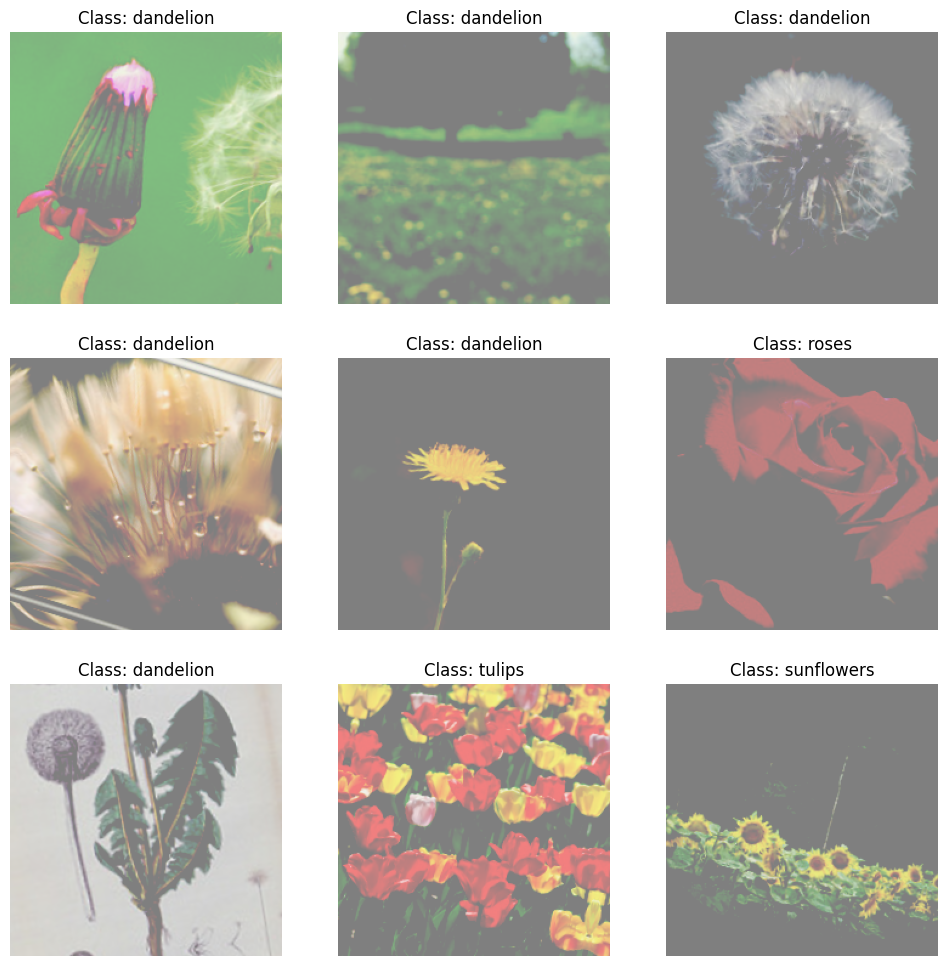

In [11]:
# Running this cell multiple times displays the same first 9 images in different random data augmentations

plt.figure(figsize=(12, 12))
for X_batch, y_batch in val_set.take(1):
    X_batch_augmented = data_augmentation(X_batch, training=True)
    for index in range(9):
        plt.subplot(3, 3, index + 1)
        # We must rescale the images to the 0-1 range for imshow(), and also
        # clip the result to that range, because data augmentation may
        # make some values go out of bounds (e.g., RandomContrast in this case).
        plt.imshow(np.clip((X_batch_augmented[index] + 1) / 2, 0, 1))
        plt.title(f"Class: {class_names[y_batch[index]]}")
        plt.axis("off")

plt.show()

Loads the pretrained model, without its top layers, and replace them with one specific to this flower classification task.

In [12]:
# NOTE THAT DOWNLOADING XCEPTION WEIGHTS MAY TAKE SEVERAL MINUTES TO COMPLETE

tf.random.set_seed(42)

base_model = tf.keras.applications.xception.Xception(weights="imagenet", include_top=False)
avg = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
output = tf.keras.layers.Dense(n_classes, activation="softmax")(avg)
model = tf.keras.Model(inputs=base_model.input, outputs=output)

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Train the model for a few epochs, while keeping the base model weights fixed.

In [13]:
for layer in base_model.layers:
    layer.trainable = False

In [14]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.1, momentum=0.9)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

# NOTE THAT FOLLOWING MODEL TRAINING MAY TAKE SEVERAL MINUTES TO COMPLETE ON CPU
history = model.fit(train_set, validation_data=val_set, epochs=3)

Epoch 1/3
86/86 ━━━━━━━━━━━━━━━━━━━━ 37s 227ms/step - accuracy: 0.7029 - loss: 1.0785 - val_accuracy: 0.8566 - val_loss: 0.7249
Epoch 2/3
86/86 ━━━━━━━━━━━━━━━━━━━━ 22s 148ms/step - accuracy: 0.9037 - loss: 0.3948 - val_accuracy: 0.8385 - val_loss: 0.7730
Epoch 3/3
86/86 ━━━━━━━━━━━━━━━━━━━━ 19s 143ms/step - accuracy: 0.9346 - loss: 0.2048 - val_accuracy: 0.8584 - val_loss: 0.6716


In [15]:
for indices in zip(range(33), range(33, 66), range(66, 99), range(99, 132)):
    for idx in indices:
        print(f"{idx:3}: {base_model.layers[idx].name:22}", end="")
    print()

  0: input_layer_2          33: block4_pool            66: block8_sepconv1_act    99: block11_sepconv2_act  
  1: block1_conv1           34: batch_normalization_2  67: block8_sepconv1       100: block11_sepconv2      
  2: block1_conv1_bn        35: add_2                  68: block8_sepconv1_bn    101: block11_sepconv2_bn   
  3: block1_conv1_act       36: block5_sepconv1_act    69: block8_sepconv2_act   102: block11_sepconv3_act  
  4: block1_conv2           37: block5_sepconv1        70: block8_sepconv2       103: block11_sepconv3      
  5: block1_conv2_bn        38: block5_sepconv1_bn     71: block8_sepconv2_bn    104: block11_sepconv3_bn   
  6: block1_conv2_act       39: block5_sepconv2_act    72: block8_sepconv3_act   105: add_9                 
  7: block2_sepconv1        40: block5_sepconv2        73: block8_sepconv3       106: block12_sepconv1_act  
  8: block2_sepconv1_bn     41: block5_sepconv2_bn     74: block8_sepconv3_bn    107: block12_sepconv1      
  9: block2_sepconv

Weights of our new top layers do not seem to be too bad, so, top part of the base model can be made trainable again, and training can be continued, but with a lower learning rate.

In [ ]:
# [OPTIONAL], Additionally, the above model with non-trainable Xception weights can be saved for later references.
# model.save("./models/my_tf-flowers_model_on_non-trainable_xception_weights")

In [16]:
for layer in base_model.layers[56:]:
    layer.trainable = True

In [18]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

history = model.fit(train_set, validation_data=val_set, epochs=10)

Epoch 1/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 47s 320ms/step - accuracy: 0.8704 - loss: 0.3927 - val_accuracy: 0.8475 - val_loss: 0.6887
Epoch 2/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 26s 283ms/step - accuracy: 0.9815 - loss: 0.0621 - val_accuracy: 0.8947 - val_loss: 0.3808
Epoch 3/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 25s 285ms/step - accuracy: 0.9903 - loss: 0.0275 - val_accuracy: 0.8947 - val_loss: 0.3517
Epoch 4/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 41s 288ms/step - accuracy: 0.9940 - loss: 0.0233 - val_accuracy: 0.9002 - val_loss: 0.3443
Epoch 5/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 41s 288ms/step - accuracy: 0.9974 - loss: 0.0083 - val_accuracy: 0.9220 - val_loss: 0.3371
Epoch 6/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 41s 289ms/step - accuracy: 0.9932 - loss: 0.0142 - val_accuracy: 0.9038 - val_loss: 0.3652
Epoch 7/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 41s 295ms/step - accuracy: 0.9973 - loss: 0.0051 - val_accuracy: 0.9038 - val_loss: 0.3653
Epoch 8/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 27s 300ms/step - accuracy: 0.9989 - loss: 0.0031 - val_accu